In [20]:
import yaml
import cv2
import matplotlib.pyplot as plt
from types import SimpleNamespace
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import json
import rasterio
import glob
from scipy.stats import ttest_rel

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 5         # 全域預設的文字大小
mpl.rcParams['axes.labelsize'] = 7    # x, y 軸標籤 (label) 的文字大小
mpl.rcParams['xtick.labelsize'] = 5    # x 軸刻度 (tick) 的文字大小
mpl.rcParams['ytick.labelsize'] = 5   # y 軸刻度 (tick) 的文字大小
mpl.rcParams['legend.fontsize'] = 5
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2.5
mpl.rcParams['ytick.major.size'] = 2.5
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['boxplot.boxprops.linewidth'] = 0.5
mpl.rcParams['boxplot.medianprops.linewidth'] = 0.5
mpl.rcParams['boxplot.whiskerprops.linewidth'] = 0.5
mpl.rcParams['boxplot.capprops.linewidth'] = 0.5
mpl.rcParams['boxplot.flierprops.markersize'] = 0.5
mpl.rcParams['legend.frameon'] = False

In [2]:
def create_folder(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

# 顯著性標示函式
def get_significance_stars(p_value):
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return 'n.s.'
    
def mm2inch(*values):
    return [v / 25.4 for v in values]

In [3]:
run_id = 'e52c8ac9a3e24c75ac871f63bbdea060'
exp_id = '115656750127464383'
conf_path = os.path.join('mlruns', exp_id, run_id, 'artifacts', 'conf')
predicts_path = os.path.join('predicts', run_id)
plot_path = os.path.join('plots', run_id)
predicts_maxent_path = os.path.join('predict_maxent', run_id)

# DeepSDM configurations
DeepSDM_conf_path = os.path.join(conf_path, 'DeepSDM_conf.yaml')
with open(DeepSDM_conf_path, 'r') as f:
    DeepSDM_conf = SimpleNamespace(**yaml.load(f, Loader = yaml.FullLoader))
    
# load extent binary map
with rasterio.open(os.path.join(conf_path, 'extent_binary.tif'), 'r') as f:
    transform = f.transform
    height, width = f.shape
    lon_min, lat_max = rasterio.transform.xy(transform, 0, 0)  # 左上角
    lon_max, lat_min = rasterio.transform.xy(transform, height - 1, width - 1)  # 右下角
    meta = f.meta.copy()
    extent_binary = f.read(1)
extent_binary_extent = [lon_min, lon_max, lat_min, lat_max]

# create a plot folder of the specific exp_id
plot_path_indicompar = os.path.join(plot_path, 'Fig4_indicator_comparison')
create_folder(plot_path_indicompar)
    
# species occurrence points
with open(os.path.join(predicts_path, 'sp_inf.json'), 'r') as f:
    sp_inf = json.load(f)

In [4]:
species_list_predict = sorted(DeepSDM_conf.training_conf['species_list_predict'])

env_list = sorted(DeepSDM_conf.training_conf['env_list'])

date_list_predict = DeepSDM_conf.training_conf['date_list_predict']
date_list_train = DeepSDM_conf.training_conf['date_list_train']

In [5]:
with open(os.path.join(conf_path, 'cooccurrence_vector.json')) as f:
    coocc_vector = json.load(f)
with open(os.path.join(conf_path, 'env_information.json')) as f:
    env_info = json.load(f)

### 用舊的資料（也就是每個物種在不同時間有不同的threshold）

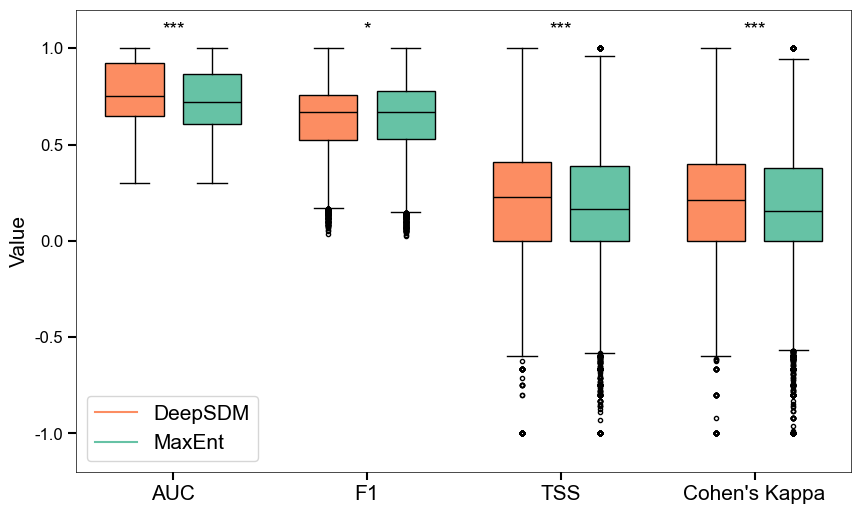

In [6]:
# 設定檔案路徑並讀取數據
file_pattern = os.path.join(predicts_maxent_path, 'all_indicator_result_all_season_num_pa*.csv')  # 根據您的需求填入 run_id
files = glob.glob(file_pattern)
indicator = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# 將指標重新命名，將 AUC 指標明確顯示為 AUC
indicator.rename(columns={
    'deepsdm_all_season_val': 'DeepSDM_AUC',
    'maxent_all_season_val': 'MaxEnt_AUC',
    'deepsdm_TSS': 'DeepSDM_TSS',
    'maxent_TSS': 'MaxEnt_TSS',
    'deepsdm_kappa': 'DeepSDM_Kappa',
    'maxent_kappa': 'MaxEnt_Kappa',
    'deepsdm_f1': 'DeepSDM_F1',
    'maxent_f1': 'MaxEnt_F1'
}, inplace=True)

# 定義指標名稱和相應的欄位
indicators = {
    'AUC': ('DeepSDM_AUC', 'MaxEnt_AUC'),
    'F1': ('DeepSDM_F1', 'MaxEnt_F1'),
    'TSS': ('DeepSDM_TSS', 'MaxEnt_TSS'),
    "Cohen's Kappa": ('DeepSDM_Kappa', 'MaxEnt_Kappa')
}

# 設置顏色
color_deepsdm = '#fc8d62'  # DeepSDM 的填充顏色
color_maxent = '#66c2a5'   # MaxEnt 的填充顏色

# 準備數據
data_deepsdm = []
data_maxent = []
ticks = []
significance_stars = []
n = []
t_stats = []
p_values = []

for indicator_name, (col_deepsdm, col_maxent) in indicators.items():
    # 篩選有效數據
    indicator_filtered = indicator[(indicator[col_deepsdm] != -9999) & (indicator[col_deepsdm].notna()) &
                                   (indicator[col_maxent] != -9999) & (indicator[col_maxent].notna())]
    n.append(len(indicator_filtered))
    
    # 添加數據至列表
    data_deepsdm.append(indicator_filtered[col_deepsdm].values)
    data_maxent.append(indicator_filtered[col_maxent].values)
    ticks.append(indicator_name)
    
    # 計算 t 檢定並獲取顯著性標示
    t_stat, p_value = ttest_rel(indicator_filtered[col_deepsdm], indicator_filtered[col_maxent])
    significance_stars.append(get_significance_stars(p_value))
    t_stats.append(t_stat)
    p_values.append(p_value)

# 定義箱型圖顏色設置函數
def set_box_color(bp, fill_color):
    for patch in bp['boxes']:
        patch.set_edgecolor('black')  # 邊框設為黑色
        patch.set_facecolor(fill_color)  # 填充顏色
    for whisker in bp['whiskers']:
        whisker.set_color('black')
    for cap in bp['caps']:
        cap.set_color('black')
    for median in bp['medians']:
        median.set_color('black')

# 定義 DeepSDM 和 MaxEnt 的位置
positions_deepsdm = np.array(range(len(data_deepsdm))) * 2.0 - 0.4
positions_maxent = np.array(range(len(data_maxent))) * 2.0 + 0.4

# 使用 plt.subplots 創建圖形和軸
fig, ax = plt.subplots(figsize=(10, 6))

# 繪製 DeepSDM 和 MaxEnt 的箱型圖，並設定填充顏色
bpl = ax.boxplot(data_deepsdm, positions=positions_deepsdm, sym='.', widths=0.6, patch_artist=True)
bpr = ax.boxplot(data_maxent, positions=positions_maxent, sym='.', widths=0.6, patch_artist=True)

# 設定顏色
set_box_color(bpl, color_deepsdm)  # 設定 DeepSDM 的填充顏色
set_box_color(bpr, color_maxent)   # 設定 MaxEnt 的填充顏色

# 繪製圖例
ax.plot([], c=color_deepsdm, label='DeepSDM')
ax.plot([], c=color_maxent, label='MaxEnt')
ax.legend(loc='lower left', fontsize=15)

# 顯示顯著性標示
for i, star in enumerate(significance_stars):
    x_pos = (positions_deepsdm[i] + positions_maxent[i]) / 2  # 計算顯示位置
    y_max = max(np.max(data_deepsdm[i]), np.max(data_maxent[i]))  # 取得最高值
    ax.text(x_pos, y_max + 0.05, star, ha='center', va='bottom', fontsize=14, color='black')

# 設置 x 軸標籤與範圍
ax.set_xticks(range(0, len(ticks) * 2, 2))
ax.set_xticklabels(ticks, size=15)
ax.set_xlim(-1, len(ticks) * 2 - 1)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='both', length=6, width=1.5)  # 調整長度和寬度

# 設置 y 軸的範圍為 -1 到 1.2
ax.set_ylim(-1.2, 1.2)

# 設置 y 軸的刻度
ax.set_yticks(np.arange(-1, 1.1, 0.5))  # 範圍為 -1 到 1，間距為 0.5
ax.set_yticklabels(np.arange(-1, 1.1, 0.5), size=12)  # 設定標籤大小為 12
ax.tick_params(axis='y', which='both', direction='out', length=6, width=1.5)

# 移除 y 軸的網格線
ax.grid(False)

output_path = os.path.join(plot_path_indicompar, 'indicator_boxplot.pdf')
# plt.savefig(output_path, dpi = 200, transparent = True, bbox_inches = 'tight')


# 調整佈局
plt.show()

In [7]:
print(p_values)
print(n)
print(t_stats)

[2.054666217398735e-74, 0.03787403997701713, 2.2948546047780045e-86, 3.18287727378738e-75]
[12084, 8971, 11648, 11648]
[18.377263306002973, -2.076522680009769, 19.862447776488548, 18.485856876060947]


In [8]:
indicator.to_csv(os.path.join(plot_path_indicompar, 'indicator.csv'), index = None)

### 用新的資料aka一個物種只有一個threshold

In [9]:
# 設定檔案路徑並讀取數據
file_pattern = os.path.join(predicts_maxent_path, 'only_threshold_depend_indi_*.csv')  # 根據您的需求填入 run_id
files = glob.glob(file_pattern)
indicator = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

file_pattern = os.path.join(predicts_maxent_path, 'all_indicator_result_all_season_num_pa*.csv')  # 根據您的需求填入 run_id
files = glob.glob(file_pattern)
indicator_multithreshold = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

indicator_multithreshold[['species', 'date']] = indicator_multithreshold['spdate'].str.rsplit('_', n=1, expand=True)

# 確保日期格式一致
indicator_multithreshold['date'] = pd.to_datetime(indicator_multithreshold['date'])
indicator['date'] = pd.to_datetime(indicator['date'])

# 選擇要合併的欄位
columns_to_merge = [
    'species', 'date', 
    'maxent_all_season_val', 'maxent_all_season_train', 'maxent_all_season_all',
    'deepsdm_all_season_val', 'deepsdm_all_season_train', 'deepsdm_all_season_all'
]
indicator_multithreshold_subset = indicator_multithreshold[columns_to_merge]

# 合併 DataFrame
indicator_merged = indicator.merge(indicator_multithreshold_subset, on=['species', 'date'], how='left')

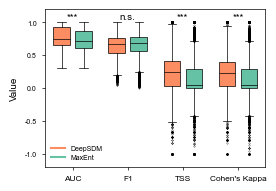

In [25]:
# 將指標重新命名，將 AUC 指標明確顯示為 AUC
indicator_merged.rename(columns={
    'deepsdm_all_season_val': 'DeepSDM_AUC', 
    'maxent_all_season_val': 'MaxEnt_AUC', 
    'deepsdm_val_TSS': 'DeepSDM_TSS',
    'maxent_val_TSS': 'MaxEnt_TSS',
    'deepsdm_val_kappa': 'DeepSDM_Kappa',
    'maxent_val_kappa': 'MaxEnt_Kappa',
    'deepsdm_val_f1': 'DeepSDM_F1',
    'maxent_val_f1': 'MaxEnt_F1'
}, inplace=True)

# 定義指標名稱和相應的欄位
indicators = {
    'AUC': ('DeepSDM_AUC', 'MaxEnt_AUC'), 
    'F1': ('DeepSDM_F1', 'MaxEnt_F1'),
    'TSS': ('DeepSDM_TSS', 'MaxEnt_TSS'),
    "Cohen's Kappa": ('DeepSDM_Kappa', 'MaxEnt_Kappa')
}

# 設置顏色
color_deepsdm = '#fc8d62'  # DeepSDM 的填充顏色
color_maxent = '#66c2a5'   # MaxEnt 的填充顏色

# 準備數據
data_deepsdm = []
data_maxent = []
ticks = []
significance_stars = []
n = []
t_stats = []
p_values = []

for indicator_name, (col_deepsdm, col_maxent) in indicators.items():
    # 篩選有效數據
    indicator_filtered = indicator_merged[(indicator_merged[col_deepsdm] != -9999) & (indicator_merged[col_deepsdm].notna()) &
                                          (indicator_merged[col_maxent] != -9999) & (indicator_merged[col_maxent].notna())]
    n.append(len(indicator_filtered))
    
    # 添加數據至列表
    data_deepsdm.append(indicator_filtered[col_deepsdm].values)
    data_maxent.append(indicator_filtered[col_maxent].values)
    ticks.append(indicator_name)
    
    # 計算 t 檢定並獲取顯著性標示
    t_stat, p_value = ttest_rel(indicator_filtered[col_deepsdm], indicator_filtered[col_maxent])
    significance_stars.append(get_significance_stars(p_value))
    t_stats.append(t_stat)
    p_values.append(p_value)

# 定義箱型圖顏色設置函數
def set_box_color(bp, fill_color):
    for patch in bp['boxes']:
        patch.set_edgecolor('black')  # 邊框設為黑色
        patch.set_facecolor(fill_color)  # 填充顏色
    for whisker in bp['whiskers']:
        whisker.set_color('black')
    for cap in bp['caps']:
        cap.set_color('black')
    for median in bp['medians']:
        median.set_color('black')

# 定義 DeepSDM 和 MaxEnt 的位置
positions_deepsdm = np.array(range(len(data_deepsdm))) * 2.0 - 0.4
positions_maxent = np.array(range(len(data_maxent))) * 2.0 + 0.4

# 使用 plt.subplots 創建圖形和軸
fig, ax = plt.subplots(figsize=mm2inch(70, 50), gridspec_kw = {'left': 0.15, 'right': 0.95, 
                                                               'bottom': 0.15, 'top': 0.95})

# 繪製 DeepSDM 和 MaxEnt 的箱型圖，並設定填充顏色
bpl = ax.boxplot(data_deepsdm, positions=positions_deepsdm, sym='.', widths=0.6, patch_artist=True)
bpr = ax.boxplot(data_maxent, positions=positions_maxent, sym='.', widths=0.6, patch_artist=True)

# 設定顏色
set_box_color(bpl, color_deepsdm)  # 設定 DeepSDM 的填充顏色
set_box_color(bpr, color_maxent)   # 設定 MaxEnt 的填充顏色

# 繪製圖例
ax.plot([], c=color_deepsdm, label='DeepSDM')
ax.plot([], c=color_maxent, label='MaxEnt')
ax.legend(loc='lower left')

# 顯示顯著性標示
for i, star in enumerate(significance_stars):
    x_pos = (positions_deepsdm[i] + positions_maxent[i]) / 2  # 計算顯示位置
    y_max = max(np.max(data_deepsdm[i]), np.max(data_maxent[i]))  # 取得最高值
    ax.text(x_pos, y_max + 0.02, star, ha='center', va='bottom', fontsize=7, color='black')

# 設置 x 軸標籤與範圍
ax.set_xticks(range(0, len(ticks) * 2, 2))
ax.set_xticklabels(ticks, fontsize = 6)
ax.set_xlim(-1, len(ticks) * 2 - 1)
ax.set_ylabel('Value')

# 設置 y 軸的範圍為 -1 到 1.2
ax.set_ylim(-1.2, 1.2)

# 設置 y 軸的刻度
ax.set_yticks(np.arange(-1, 1.1, 0.5))  # 範圍為 -1 到 1，間距為 0.5
ax.set_yticklabels(np.arange(-1, 1.1, 0.5))  # 設定標籤大小為 12

# 移除 y 軸的網格線
ax.grid(False)

output_path = os.path.join(plot_path_indicompar, 'indicator_boxplot_constantthreshold.pdf')
plt.savefig(output_path, dpi = 500, transparent = True)


# 調整佈局
plt.show()

In [22]:
print(p_values)
print(n)
print(t_stats)

[2.668200632193535e-74, 0.12112426733168105, 6.937819847530273e-185, 1.092047177626324e-170]
[12076, 8422, 11641, 11641]
[18.36276954797104, -1.5502284707460843, 29.530515416289237, 28.32055322878541]


In [39]:
import pandas as pd
import numpy as np

# Step 1: 提取物種名
indicator['species'] = indicator['spdate'].str.split('_').str[:-1].str.join('_')

# Step 2: 替換 -9999 為 NaN，方便排除無效值
indicator.replace(-9999, np.nan, inplace=True)

# Step 3: 選擇數值型列（排除非數值列，如 spdate 和 species）
numeric_columns = indicator.select_dtypes(include=[np.number]).columns

# Step 4: 分組計算每個物種的平均值，忽略 NaN 值
species_mean = (
    indicator.groupby('species')[numeric_columns]
    .mean()  # mean 自動忽略 NaN
    .reset_index()
)

# 查看結果
species_mean.to_csv(os.path.join(plot_path_indicompar, 'indicator_mean.csv'), index = None)


KeyError: 'spdate'

### 只計算物種出現數少於前幾%

In [44]:
sp_num = {}
for sp in species_list_predict:
    p_season = (indicator[indicator['spdate'].apply(lambda x: f"{x.split('_')[0]}_{x.split('_')[1]}") == sp]['p_season'])
    p_season = np.where(p_season == -9999, 0, p_season)
    sp_num[sp] = sum(p_season)/len(p_season)    

KeyError: 'spdate'

In [13]:
percentile = 25
threshold = np.nanpercentile(np.array(list(sp_num.values())), percentile)

In [14]:
species_list_threshold = []
for (sp, num) in sp_num.items():
    if num <= threshold:
        species_list_threshold.append(sp)
print(species_list_threshold)
print(len(species_list_threshold))

['Cinclus_pallasii', 'Coracina_macei', 'Dendrocopos_leucotos', 'Egretta_sacra', 'Enicurus_scouleri', 'Ficedula_hyperythra', 'Gallirallus_striatus', 'Garrulax_ruficeps', 'Glaucidium_brodiei', 'Hirundapus_cochinchinensis', 'Ketupa_flavipes', 'Nisaetus_nipalensis', 'Passer_cinnamomeus', 'Picus_canus', 'Poecile_varius', 'Porzana_fusca', 'Prinia_striata', 'Prunella_collaris', 'Pyrrhula_nipalensis', 'Pyrrhula_owstoni', 'Rallina_eurizonoides', 'Strix_leptogrammica', 'Strix_nivicolum', 'Suthora_verreauxi', 'Syrmaticus_mikado', 'Tarsiger_indicus', 'Treron_formosae', 'Troglodytes_troglodytes', 'Turdus_poliocephalus', 'Tyto_longimembris', 'Zoothera_dauma']
31


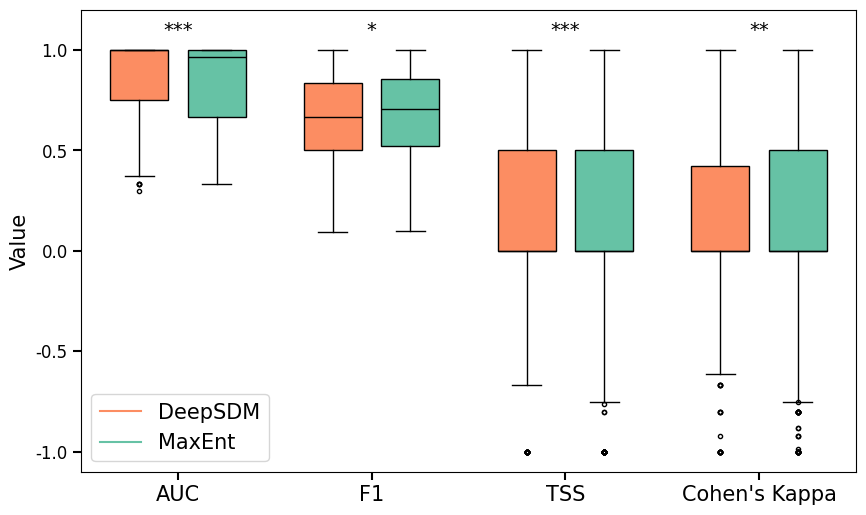

In [15]:
# 設定檔案路徑並讀取數據
file_pattern = os.path.join(predicts_maxent_path, 'all_indicator_result_all_season_num_pa*.csv')  # 根據您的需求填入 run_id
files = glob.glob(file_pattern)
indicator = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# 將指標重新命名，將 AUC 指標明確顯示為 AUC
indicator.rename(columns={
    'deepsdm_all_season_val': 'DeepSDM_AUC',
    'maxent_all_season_val': 'MaxEnt_AUC',
    'deepsdm_TSS': 'DeepSDM_TSS',
    'maxent_TSS': 'MaxEnt_TSS',
    'deepsdm_kappa': 'DeepSDM_Kappa',
    'maxent_kappa': 'MaxEnt_Kappa',
    'deepsdm_f1': 'DeepSDM_F1',
    'maxent_f1': 'MaxEnt_F1'
}, inplace=True)

# 定義指標名稱和相應的欄位
indicators = {
    'AUC': ('DeepSDM_AUC', 'MaxEnt_AUC'),
    'F1': ('DeepSDM_F1', 'MaxEnt_F1'),
    'TSS': ('DeepSDM_TSS', 'MaxEnt_TSS'),
    "Cohen's Kappa": ('DeepSDM_Kappa', 'MaxEnt_Kappa')
}

# 設置顏色
color_deepsdm = '#fc8d62'  # DeepSDM 的填充顏色
color_maxent = '#66c2a5'   # MaxEnt 的填充顏色

# 準備數據
data_deepsdm = []
data_maxent = []
ticks = []
significance_stars = []
n = []
t_stats = []
p_values = []

for indicator_name, (col_deepsdm, col_maxent) in indicators.items():
    # 篩選有效數據
    indicator_filtered = indicator[(indicator[col_deepsdm] != -9999) & (indicator[col_deepsdm].notna()) &
                                   (indicator[col_maxent] != -9999) & (indicator[col_maxent].notna())]
    #篩選稀有種
    indicator_filtered = indicator_filtered[indicator_filtered['spdate'].apply(lambda x : f"{x.split('_')[0]}_{x.split('_')[1]}" in species_list_threshold)]
    n.append(len(indicator_filtered))
    
    # 添加數據至列表
    data_deepsdm.append(indicator_filtered[col_deepsdm].values)
    data_maxent.append(indicator_filtered[col_maxent].values)
    ticks.append(indicator_name)
    
    # 計算 t 檢定並獲取顯著性標示
    t_stat, p_value = ttest_rel(indicator_filtered[col_deepsdm], indicator_filtered[col_maxent])
    significance_stars.append(get_significance_stars(p_value))
    t_stats.append(t_stat)
    p_values.append(p_value)


# 定義箱型圖顏色設置函數
def set_box_color(bp, fill_color):
    for patch in bp['boxes']:
        patch.set_edgecolor('black')  # 邊框設為黑色
        patch.set_facecolor(fill_color)  # 填充顏色
    for whisker in bp['whiskers']:
        whisker.set_color('black')
    for cap in bp['caps']:
        cap.set_color('black')
    for median in bp['medians']:
        median.set_color('black')

# 定義 DeepSDM 和 MaxEnt 的位置
positions_deepsdm = np.array(range(len(data_deepsdm))) * 2.0 - 0.4
positions_maxent = np.array(range(len(data_maxent))) * 2.0 + 0.4

# 使用 plt.subplots 創建圖形和軸
fig, ax = plt.subplots(figsize=(10, 6))

# 繪製 DeepSDM 和 MaxEnt 的箱型圖，並設定填充顏色
bpl = ax.boxplot(data_deepsdm, positions=positions_deepsdm, sym='.', widths=0.6, patch_artist=True)
bpr = ax.boxplot(data_maxent, positions=positions_maxent, sym='.', widths=0.6, patch_artist=True)

# 設定顏色
set_box_color(bpl, color_deepsdm)  # 設定 DeepSDM 的填充顏色
set_box_color(bpr, color_maxent)   # 設定 MaxEnt 的填充顏色

# 繪製圖例
ax.plot([], c=color_deepsdm, label='DeepSDM')
ax.plot([], c=color_maxent, label='MaxEnt')
ax.legend(loc='lower left', fontsize=15)

# 顯示顯著性標示
for i, star in enumerate(significance_stars):
    x_pos = (positions_deepsdm[i] + positions_maxent[i]) / 2  # 計算顯示位置
    y_max = max(np.max(data_deepsdm[i]), np.max(data_maxent[i]))  # 取得最高值
    ax.text(x_pos, y_max + 0.05, star, ha='center', va='bottom', fontsize=14, color='black')

# 設置 x 軸標籤與範圍
ax.set_xticks(range(0, len(ticks) * 2, 2))
ax.set_xticklabels(ticks, size=15)
ax.set_xlim(-1, len(ticks) * 2 - 1)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='both', length=6, width=1.5)  # 調整長度和寬度

# 設置 y 軸的範圍為 -1 到 1.2
ax.set_ylim(-1.1, 1.2)

# 設置 y 軸的刻度
ax.set_yticks(np.arange(-1, 1.1, 0.5))  # 範圍為 -1 到 1，間距為 0.5
ax.set_yticklabels(np.arange(-1, 1.1, 0.5), size=12)  # 設定標籤大小為 12
ax.tick_params(axis='y', which='both', direction='out', length=6, width=1.5)

# 移除 y 軸的網格線
ax.grid(False)

output_path = os.path.join(plot_path_indicompar, f'indicator_boxplot_rarespecies_percentile{percentile}.pdf')
plt.savefig(output_path, dpi = 200, transparent = True, bbox_inches = 'tight')


# 調整佈局
plt.show()


In [16]:
print(p_values)
print(n)
print(t_stats)

[1.6239120921025307e-13, 0.02928435129644571, 0.00011964931866172364, 0.0022782251124870544]
[1769, 667, 1499, 1499]
[7.434781327809332, -2.1843524398569922, 3.857009816581439, 3.0565987631673233]


### 用新的資料aka一個物種只有一個threshold

In [100]:
sp_num = {}
for sp in species_list_predict:
    p_points = indicator_merged.loc[indicator_merged['species'] == sp][['train_points', 'val_points']]
    p_points = p_points.where(p_points != -9999, 0)
    sp_num[sp] = p_points.sum().sum()/p_points.shape[0]

percentile = 25
threshold = np.nanpercentile(np.array(list(sp_num.values())), percentile)

species_list_threshold = []
for (sp, num) in sp_num.items():
    if num <= threshold:
        species_list_threshold.append(sp)
print(species_list_threshold)
print(len(species_list_threshold))

In [114]:
# 設定檔案路徑並讀取數據
file_pattern = os.path.join(predicts_maxent_path, 'only_threshold_depend_indi_*.csv')  # 根據您的需求填入 run_id
files = glob.glob(file_pattern)
indicator = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

file_pattern = os.path.join(predicts_maxent_path, 'all_indicator_result_all_season_num_pa*.csv')  # 根據您的需求填入 run_id
files = glob.glob(file_pattern)
indicator_multithreshold = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

indicator_multithreshold[['species', 'date']] = indicator_multithreshold['spdate'].str.rsplit('_', n=1, expand=True)

# 選擇要合併的欄位
columns_to_merge = [
    'species', 'date', 
    'maxent_all_season_val', 'maxent_all_season_train', 'maxent_all_season_all',
    'deepsdm_all_season_val', 'deepsdm_all_season_train', 'deepsdm_all_season_all'
]
indicator_multithreshold_subset = indicator_multithreshold[columns_to_merge]

# 合併 DataFrame
indicator_merged = indicator.merge(indicator_multithreshold_subset, on=['species', 'date'], how='left')

indicator_merged = indicator_merged.loc[indicator_merged.species.isin(species_list_threshold)][:]

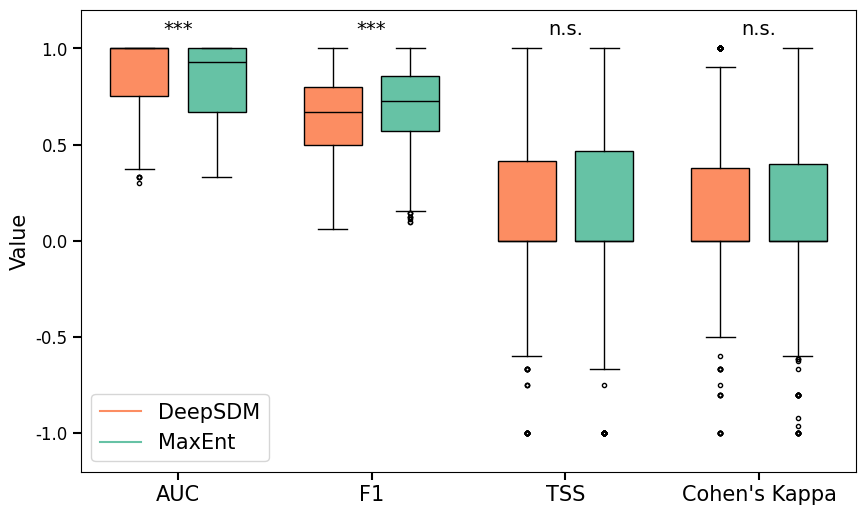

In [116]:
# 將指標重新命名，將 AUC 指標明確顯示為 AUC
indicator_merged.rename(columns={
    'deepsdm_all_season_val': 'DeepSDM_AUC', 
    'maxent_all_season_val': 'MaxEnt_AUC', 
    'deepsdm_val_TSS': 'DeepSDM_TSS',
    'maxent_val_TSS': 'MaxEnt_TSS',
    'deepsdm_val_kappa': 'DeepSDM_Kappa',
    'maxent_val_kappa': 'MaxEnt_Kappa',
    'deepsdm_val_f1': 'DeepSDM_F1',
    'maxent_val_f1': 'MaxEnt_F1'
}, inplace=True)

# 定義指標名稱和相應的欄位
indicators = {
    'AUC': ('DeepSDM_AUC', 'MaxEnt_AUC'), 
    'F1': ('DeepSDM_F1', 'MaxEnt_F1'),
    'TSS': ('DeepSDM_TSS', 'MaxEnt_TSS'),
    "Cohen's Kappa": ('DeepSDM_Kappa', 'MaxEnt_Kappa')
}

# 設置顏色
color_deepsdm = '#fc8d62'  # DeepSDM 的填充顏色
color_maxent = '#66c2a5'   # MaxEnt 的填充顏色

# 準備數據
data_deepsdm = []
data_maxent = []
ticks = []
significance_stars = []
n = []
t_stats = []
p_values = []

for indicator_name, (col_deepsdm, col_maxent) in indicators.items():
    # 篩選有效數據
    indicator_filtered = indicator_merged[(indicator_merged[col_deepsdm] != -9999) & (indicator_merged[col_deepsdm].notna()) &
                                          (indicator_merged[col_maxent] != -9999) & (indicator_merged[col_maxent].notna())]
    n.append(len(indicator_filtered))
    
    # 添加數據至列表
    data_deepsdm.append(indicator_filtered[col_deepsdm].values)
    data_maxent.append(indicator_filtered[col_maxent].values)
    ticks.append(indicator_name)
    
    # 計算 t 檢定並獲取顯著性標示
    t_stat, p_value = ttest_rel(indicator_filtered[col_deepsdm], indicator_filtered[col_maxent])
    significance_stars.append(get_significance_stars(p_value))
    t_stats.append(t_stat)
    p_values.append(p_value)

# 定義箱型圖顏色設置函數
def set_box_color(bp, fill_color):
    for patch in bp['boxes']:
        patch.set_edgecolor('black')  # 邊框設為黑色
        patch.set_facecolor(fill_color)  # 填充顏色
    for whisker in bp['whiskers']:
        whisker.set_color('black')
    for cap in bp['caps']:
        cap.set_color('black')
    for median in bp['medians']:
        median.set_color('black')

# 定義 DeepSDM 和 MaxEnt 的位置
positions_deepsdm = np.array(range(len(data_deepsdm))) * 2.0 - 0.4
positions_maxent = np.array(range(len(data_maxent))) * 2.0 + 0.4

# 使用 plt.subplots 創建圖形和軸
fig, ax = plt.subplots(figsize=(10, 6))

# 繪製 DeepSDM 和 MaxEnt 的箱型圖，並設定填充顏色
bpl = ax.boxplot(data_deepsdm, positions=positions_deepsdm, sym='.', widths=0.6, patch_artist=True)
bpr = ax.boxplot(data_maxent, positions=positions_maxent, sym='.', widths=0.6, patch_artist=True)

# 設定顏色
set_box_color(bpl, color_deepsdm)  # 設定 DeepSDM 的填充顏色
set_box_color(bpr, color_maxent)   # 設定 MaxEnt 的填充顏色

# 繪製圖例
ax.plot([], c=color_deepsdm, label='DeepSDM')
ax.plot([], c=color_maxent, label='MaxEnt')
ax.legend(loc='lower left', fontsize=15)

# 顯示顯著性標示
for i, star in enumerate(significance_stars):
    x_pos = (positions_deepsdm[i] + positions_maxent[i]) / 2  # 計算顯示位置
    y_max = max(np.max(data_deepsdm[i]), np.max(data_maxent[i]))  # 取得最高值
    ax.text(x_pos, y_max + 0.05, star, ha='center', va='bottom', fontsize=14, color='black')

# 設置 x 軸標籤與範圍
ax.set_xticks(range(0, len(ticks) * 2, 2))
ax.set_xticklabels(ticks, size=15)
ax.set_xlim(-1, len(ticks) * 2 - 1)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='both', length=6, width=1.5)  # 調整長度和寬度

# 設置 y 軸的範圍為 -1 到 1.2
ax.set_ylim(-1.2, 1.2)

# 設置 y 軸的刻度
ax.set_yticks(np.arange(-1, 1.1, 0.5))  # 範圍為 -1 到 1，間距為 0.5
ax.set_yticklabels(np.arange(-1, 1.1, 0.5), size=12)  # 設定標籤大小為 12
ax.tick_params(axis='y', which='both', direction='out', length=6, width=1.5)

# 移除 y 軸的網格線
ax.grid(False)

output_path = os.path.join(plot_path_indicompar, 'indicator_boxplot.pdf')
# plt.savefig(output_path, dpi = 200, transparent = True, bbox_inches = 'tight')


# 調整佈局
plt.show()

In [117]:
print(p_values)
print(n)
print(t_stats)

[1.0138881833878101e-17, 2.743461479893557e-09, 0.11934233323469205, 0.7905983101304632]
[1993, 701, 1705, 1705]
[8.653128961423501, -6.024336515486227, 1.5583232578292725, 0.26557546313320596]
